<h1 style='color: green; font-size: 36px; font-weight: bold;'>Análise de data- Pressão Arterial</h1>

## Importing Libraries

In [ ]:
#MATPLOTLIB
import matplotlib.pyplot as plt
%matplotlib inline

from plotnine import *

#PANDAS
import pandas as pd
#pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
import numpy as np

#STATSMODEL
import statsmodels.api as sm

#SEABORN
import seaborn as sns #library especializada em visualização de data estatísticos e baseada em matplotlib().

#SCIPY
import scipy.stats as stats
from scipy.stats import normaltest #A função *normaltest* testa a hipótese nula $H_0$ de que a amostra é proveniente de uma distribuição normal.

#SKLEARN
from sklearn.cluster import KMeans  #não deterministico
from sklearn import metrics

## Bibliotecas opcionais


In [ ]:
import warnings

warnings.filterwarnings('ignore') # ou warnings.filterwarnings(action='once')

In [ ]:
!pip install plotnine

# <font color='red' style='font-size: 30px;'> CLUSTERIZAÇÃO KMEANS</font>
<hr style='border: 2px solid red;'>

In [ ]:
URL = 'https://github.com/paolaosouza/blood_preassure_analysis/raw/main/data.csv'
data = pd.read_csv(URL)
data.head()


,ID,Sex,Age,Length RA,Length RA seg,Circumference RA,Triceps_Skinfold RA,Muscular Circumference RA,Fat_Index RA,Length LA,Length LA seg,Circumference LA,Triceps_Skinfold LA,Muscular Circumference LA,Fat_Index LA,SBP RA,DBP RA,SBP LA,DBP LA
0,1,m,23,38.8,38.00,31.5,14.7,26.9,0.27,38.2,36.50,30.8,17.7,25.3,0.33,106.5,62.0,112.5,60.5
1,2,f,20,31.8,28.83,25.3,22.3,18.3,0.48,32.2,30.43,25.0,22.3,18.0,0.48,100.0,56.5,102.0,56.5
2,4,f,20,35.1,34.13,22.4,24.0,14.9,0.56,34.0,33.00,22.8,23.7,15.4,0.55,98.5,58.5,95.0,59.0
3,5,m,26,35.9,34.10,27.9,9.0,25.1,0.19,35.0,33.67,27.4,6.3,25.4,0.14,122.0,66.0,121.5,70.5
4,6,f,19,31.7,29.43,28.9,37.3,17.1,0.65,31.8,29.80,29.5,34.3,18.7,0.60,101.5,64.0,101.5,64.5


In [ ]:
data.loc[data['ID'] == 495, 'ID'] = [495, 1000]
data.drop(columns=['Age', 'Sex', 'Length RA', 'Length LA', 'Muscular Circumference RA', 'Muscular Circumference LA',], inplace=True)
data_bd = data[["ID", 'Length RA seg', 'Circumference RA', 'Triceps_Skinfold RA', 'Fat_Index RA','DBP RA','SBP RA']].sort_values("ID")
data_be = data[["ID", 'Length LA seg', 'Circumference LA', 'Triceps_Skinfold LA', 'Fat_Index LA','DBP LA','SBP LA']].sort_values("ID")

data_bd['arm'] = 'right'
data_be['arm'] = 'left'

data_bd.columns = ["id",'Length', 'Circumference', 'Triceps_Skinfold', 'Fat_Index','DBP', 'SBP', 'arm']
data_be.columns = ['id','Length', 'Circumference', 'Triceps_Skinfold', 'Fat_Index','DBP', 'SBP', 'arm']

data_be['SBP_ob'] = data_bd['SBP']
data_bd['SBP_ob'] = data_be['SBP']

data_dobrados = pd.concat([data_bd, data_be]).sort_values("id")
data_dobrados.index = list(range(1,data_dobrados.shape[0]+1))
data_dobrados.to_parquet("data_dobrados_r.parquet")
data_dobrados.head()

,id,Length,Circumference,Triceps_Skinfold,Fat_Index,DBP,SBP,arm,SBP_ob
1,1,38.00,31.5,14.7,0.27,62.0,106.5,right,112.5
2,1,36.50,30.8,17.7,0.33,60.5,112.5,left,106.5
3,2,28.83,25.3,22.3,0.48,56.5,100.0,right,102.0
4,2,30.43,25.0,22.3,0.48,56.5,102.0,left,100.0
5,4,34.13,22.4,24.0,0.56,58.5,98.5,right,95.0


In [ ]:
data_right = data_dobrados.query("arm == 'right'").drop(["arm", "SBP_ob"],axis=1).drop_duplicates(subset=['id'])
data_left  = data_dobrados.query("arm == 'left'" ).drop(["arm", "SBP_ob"],axis=1).drop_duplicates(subset=['id'])
data_left.columns = [x + "_left"  if x != 'id' else x for x in data_left.columns]
data_right.columns = [x + "_right" if x != 'id' else x for x in data_right.columns]
dado_final = data_left.merge(data_right, on='id', how='inner').drop("id", axis=1)
dado_final.head()

,Length_left,Circumference_left,Triceps_Skinfold_left,Fat_Index_left,DBP_left,SBP_left,Length_right,Circumference_right,Triceps_Skinfold_right,Fat_Index_right,DBP_right,SBP_right
0,36.50,30.8,17.7,0.33,60.5,112.5,38.00,31.5,14.7,0.27,62.0,106.5
1,30.43,25.0,22.3,0.48,56.5,102.0,28.83,25.3,22.3,0.48,56.5,100.0
2,33.00,22.8,23.7,0.55,59.0,95.0,34.13,22.4,24.0,0.56,58.5,98.5
3,33.67,27.4,6.3,0.14,70.5,121.5,34.10,27.9,9.0,0.19,66.0,122.0
4,29.80,29.5,34.3,0.60,64.5,101.5,29.43,28.9,37.3,0.65,64.0,101.5


## <font color=green>TODOS OS data dobrados</font>

### Normalização de data

Os valores de cada atributo devem estar no mesmo intervalo, caso contrário o algoritmo de agrupamento pode acabar priorizando somente alguns atributos.

In [ ]:
from sklearn.preprocessing import Normalizer
#data_dobrados_normalizados =  data_dobrados.copy()
#data_dobrados_normalizados.drop(columns=["arm"], inplace = True)
values = Normalizer().fit_transform(dado_final.values)
print(values)

[[0.19040021 0.16066648 0.09233106 ... 0.00140844 0.32341954 0.55555131]
 [0.17337474 0.14243735 0.12705411 ... 0.0027348  0.3219084  0.56974938]
 [0.19038519 0.13153886 0.13673118 ... 0.00323078 0.33750102 0.56827095]
 ...
 [0.18623883 0.13014279 0.05890083 ... 0.00196336 0.33096659 0.57498433]
 [0.18061939 0.15103518 0.08719557 ... 0.00197228 0.30622252 0.57092334]
 [0.17381144 0.1247877  0.06729622 ... 0.00138158 0.34985123 0.58605652]]


### Executando e Validando os Clusters

Na métrica de silhouette sabemos que o valor tem um intervalo que vai de -1 até 1, portanto se o cluster obter um valor positivo isso é um bom sinal.

No caso da métrica de Davies Bouldin, quanto mais próximo de 0 o valor, melhor. Já para Calinski, é melhor que o valor seja o mais alto possível.

Compararmos o valor das métricas com base em configurações diferentes do nosso algorítimo. A ideia é que assim ajustemos os parâmetros do algorítimo para obter os melhores resultados.

Mudaremos o número de clusters, afinal esse é o parâmetro que possui mais impacto. Criaremos um método que será reponsável pela execução do kmeans e calcular as três métricas de uma vez.



In [ ]:
def clustering_algorithm(n_clusters, dataset):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10) #o kmeans tem que retornar 10 vezes o mesmo valor para garantir a confiabilidade de resultado
    labels_KMeans = kmeans.fit_predict(values)
    s = metrics.silhouette_score(dataset, labels_KMeans, metric='euclidean')
    dbs = metrics.davies_bouldin_score(values,labels_KMeans)
    calinski = metrics.calinski_harabasz_score(values,labels_KMeans)
    return s,dbs,calinski, labels_KMeans, kmeans 

##### **Baseline de comparação**

In [ ]:
values.shape

(489, 12)

In [ ]:
for i in range (2, 6):
    random_data = np.random.rand(values.shape[0],values.shape[1])
    s, dbs, calinski, labels_KMeans, kmeans = clustering_algorithm(i, random_data)
    print(f"{i} clusters - {s}, {dbs}, {calinski}")

2 clusters - -0.002054325542492238, 1.1195322198133677, 324.99796713863884
3 clusters - -0.00702417183296986, 1.268102504653138, 274.9409206700408
4 clusters - -0.011794995403496033, 1.249392396095994, 257.8738640968852
5 clusters - -0.017029160563958597, 1.321917219493675, 225.9501012888026


##### **Testes**

In [ ]:
mt = []
for i in range (2, 20):
    s, dbs, calinski,labels_KMeans, kmeans = clustering_algorithm(i, values)
    mt.append([i,s,dbs,calinski])
mt_df = pd.DataFrame(mt, columns=['i', 's', 'dbs', 'calinski'])
mt_df.head()     

,i,s,dbs,calinski
0,2,0.332643,1.119532,324.997967
1,3,0.260982,1.270797,275.131820
2,4,0.248089,1.249392,257.873864
3,5,0.222594,1.324602,225.936878
4,6,0.196261,1.389263,202.735602


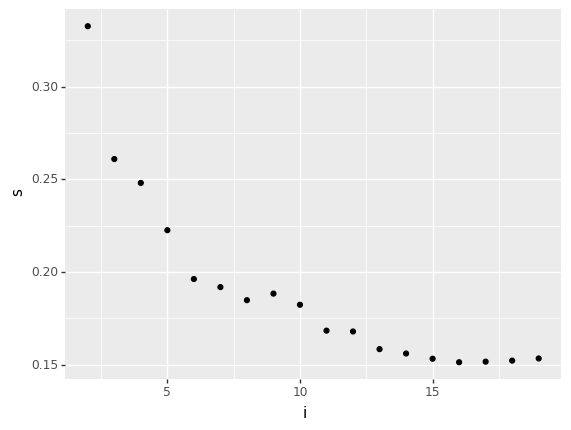

<ggplot: (8775401192045)>

In [ ]:
from plotnine import *

(
    ggplot(mt_df, aes(x='i', y='s')) + 
    geom_point()
)

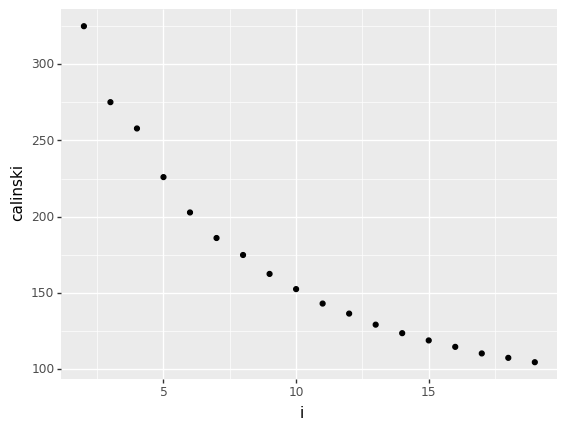

<ggplot: (8775401193297)>

In [ ]:
(
    ggplot(mt_df, aes(x='i', y='calinski')) + 
    geom_point() 
)

### Dendograma

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

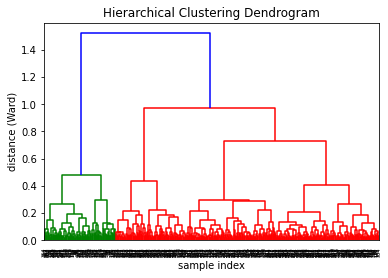

In [ ]:
Z = linkage(values, 'ward')

plt.title('Hierarchical Clustering Dendrogram')

# Plot axis labels
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')

# Make the dendrogram
dendrogram(Z, leaf_rotation=90)

# Show the graph
plt.show()

Na métrica de silhouette sabemos que o valor tem um intervalo que vai de -1 até 1, portanto se o cluster obter um valor positivo isso é um bom sinal. 
No caso da métrica de Davies Bouldin, quanto mais próximo de 0 o valor, melhor. Já para Calinski, é melhor que o valor seja o mais alto possível.

### Entendendo os valores dos atributos nos clusters

In [ ]:
dado_final["cluster"] = labels_KMeans
dado_final.groupby("cluster").describe().T

cluster                    0           1           2           3           4   \
Length_left count   26.000000   29.000000   18.000000   27.000000   25.000000   
            mean    35.453846   31.602414   30.608889   36.765556   34.116000   
            std      2.160354    1.746551    2.402161    2.213602    2.129392   
            min     31.200000   28.800000   28.000000   32.100000   29.300000   
            25%     34.000000   30.130000   29.050000   35.350000   33.000000   
...                       ...         ...         ...         ...         ...   
SBP_right   min     99.500000   99.000000   89.000000   93.500000  101.500000   
            25%    118.625000  104.000000  102.750000  107.750000  113.000000   
            50%    121.500000  110.000000  109.250000  112.500000  116.000000   
            75%    129.375000  114.500000  111.375000  116.750000  122.500000   
            max    134.000000  125.500000  133.000000  124.500000  132.500000   

cluster                    5          6           7           8           9   \
Length_left count   44.000000   22.00000   15.000000   17.000000   33.000000   
            mean    33.475000   33.77000   34.960000   35.501765   32.475758   
            std      2.045778    2.64996    2.092022    2.063929    1.840056   
            min     29.670000   29.80000   29.870000   32.000000   29.870000   
            25%     31.927500   31.27750   33.900000   34.000000   31.200000   
...                       ...        ...         ...         ...         ...   
SBP_right   min     90.500000   81.00000   85.500000   98.500000   98.500000   
            25%     98.500000   93.87500  107.000000  109.000000  103.500000   
            50%    102.750000  101.00000  112.500000  114.500000  109.000000   
            75%    107.125000  105.87500  117.000000  117.000000  113.000000   
            max    128.000000  129.00000  121.500000  129.000000  126.500000   

cluster                    10          11          12          13          14  \
Length_left count   51.000000   19.000000   29.000000   28.000000   14.000000   
            mean    33.766863   33.087895   33.823103   32.955714   31.611429   
            std      2.290146    3.233434    2.291718    2.207938    2.287558   
            min     30.000000   29.100000   29.000000   29.000000   27.900000   
            25%     32.000000   30.885000   32.800000   31.500000   30.282500   
...                       ...         ...         ...         ...         ...   
SBP_right   min     98.000000   87.000000   92.500000   89.000000  104.000000   
            25%    103.250000  102.250000  102.000000  102.250000  109.000000   
            50%    109.500000  107.500000  105.500000  105.750000  113.000000   
            75%    116.000000  116.250000  109.500000  109.000000  118.250000   
            max    133.500000  129.500000  121.000000  132.500000  121.500000   

cluster                    15          16          17          18  
Length_left count   18.000000   19.000000   25.000000   30.000000  
            mean    35.916667   33.770000   32.467200   32.019667  
            std      2.533598    1.699441    2.081489    2.337720  
            min     30.800000   31.000000   28.500000   28.500000  
            25%     33.600000   32.365000   31.000000   30.280000  
...                       ...         ...         ...         ...  
SBP_right   min    107.000000   89.500000   91.500000  101.000000  
            25%    117.000000   94.000000   99.500000  110.000000  
            50%    124.250000   98.000000  103.000000  114.500000  
            75%    132.625000  102.500000  112.500000  117.750000  
            max    139.000000  110.000000  127.000000  138.500000  

[96 rows x 19 columns]

In [ ]:
centroids = kmeans.cluster_centers_
print(centroids)

[[0.17374783 0.12935229 0.03520625 0.00079913 0.32101191 0.58847299
  0.17336315 0.12921987 0.03831579 0.00086995 0.31298762 0.59577151]
 [0.16311948 0.13157578 0.09899014 0.00214656 0.35992419 0.55409274
  0.16394363 0.13193799 0.11004678 0.00235104 0.35834032 0.56920151]
 [0.15416359 0.16128738 0.19115668 0.00307771 0.3480509  0.53502404
  0.15516798 0.1627193  0.19766945 0.0031367  0.34464922 0.54407869]
 [0.19022411 0.14303175 0.04196205 0.00091566 0.33511502 0.57340852
  0.19084    0.14388194 0.04963313 0.00106363 0.32863499 0.57602744]
 [0.17093107 0.12117091 0.03955345 0.00099156 0.35219814 0.56315918
  0.17138859 0.12205057 0.04399531 0.00109142 0.34963221 0.58608589]
 [0.18329229 0.14466675 0.09245395 0.00199186 0.34780986 0.56228216
  0.18482737 0.14503047 0.09849312 0.00210291 0.33977558 0.56422304]
 [0.19232233 0.15814213 0.11895057 0.00239324 0.32309087 0.56172132
  0.19357565 0.15739988 0.12155948 0.00244337 0.31311548 0.57215081]
 [0.18269498 0.17040604 0.0720857  0.0012

In [ ]:
max =len(centroids[0])
for i in range(max):
    print(dado_final.columns.values[i], "\n{:.4f}".format (centroids[:, i].var()))
    

Length_left 
0.0001
Circumference_left 
0.0002
Triceps_Skinfold_left 
0.0019
Fat_Index_left 
0.0000
DBP_left 
0.0005
SBP_left 
0.0002
Length_right 
0.0001
Circumference_right 
0.0002
Triceps_Skinfold_right 
0.0020
Fat_Index_right 
0.0000
DBP_right 
0.0006
SBP_right 
0.0003


selecionando atributos

In [ ]:
description = dado_final.groupby("cluster")
n = description.size()
description = print(description.mean())
print(description)



         Length_left  Circumference_left  Triceps_Skinfold_left  \
cluster                                                           
0          35.453846           26.507692               7.203846   
1          31.602414           25.489655              19.241379   
2          30.608889           32.250000              38.088889   
3          36.765556           27.762963               8.114815   
4          34.116000           24.244000               7.848000   
5          33.475000           26.500000              16.909091   
6          33.770000           27.881818              20.959091   
7          34.960000           32.606667              13.813333   
8          35.501765           30.441176               7.964706   
9          32.475758           27.206061              23.606061   
10         33.766863           24.245098              12.784314   
11         33.087895           31.584211              32.652632   
12         33.823103           24.337931              14.00344

### Visualizando os clusters

<function matplotlib.pyplot.show>

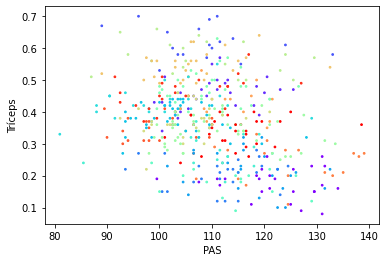

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(dado_final['SBP_right'], dado_final['Fat_Index_right'], c=labels_KMeans, s=3, cmap='rainbow')
plt.xlabel("PAS")
plt.ylabel("Tríceps")
plt.show

## <font color=green>data dobrados</font>

In [ ]:
data_dobrados.drop(columns=['arm', 'id','SBP_ob'], inplace=True)
data_dobrados.head()

,Length,Circumference,Triceps_Skinfold,Fat_Index,DBP,SBP
1,38.00,31.5,14.7,0.27,62.0,106.5
2,36.50,30.8,17.7,0.33,60.5,112.5
3,28.83,25.3,22.3,0.48,56.5,100.0
4,30.43,25.0,22.3,0.48,56.5,102.0
5,34.13,22.4,24.0,0.56,58.5,98.5


In [ ]:
data_dobrados_normalizados =  data_dobrados.copy()
values = Normalizer().fit_transform(data_dobrados_normalizados.values)


for i in range (2, 10):
    s, dbs, calinski,labels_KMeans, kmeans = clustering_algorithm(i, values)
    print(i,s,dbs,calinski, labels_KMeans[:5])  

2 0.3552860249273135 1.0598752849225208 701.6605678991081 [0 0 1 1 1]
3 0.2832458568157853 1.1924715957984098 605.3435124874551 [0 0 1 1 1]
4 0.2754656688802949 1.1318570333094349 584.7260462151042 [0 0 0 0 0]
5 0.25566546091599957 1.1831948150069622 525.7157286197843 [2 2 2 2 2]
6 0.2347721989924186 1.233970574762109 491.2783915457285 [2 2 4 2 4]
7 0.23221885275896806 1.2349905052483159 455.24656947652556 [6 6 1 1 4]
8 0.2188918814294494 1.2644850599600503 427.1673065333733 [7 7 0 0 0]
9 0.21619103913766063 1.3027073208470223 401.3956987373177 [0 0 6 6 6]


##### **Baseline de comparação**

In [ ]:
values.shape

(978, 6)

In [ ]:
for i in range (2, 6):
    random_data = np.random.rand(values.shape[0],values.shape[1])
    s, dbs, calinski, labels_KMeans, kmeans = clustering_algorithm(i, random_data)
    print(f"{i} clusters - {s}, {dbs}, {calinski}")

2 clusters - -0.0016933719833864297, 1.0598752849225208, 701.6605678991081
3 clusters - -0.007460485772341892, 1.1979529901313153, 605.4286182392593
4 clusters - -0.014545543115607818, 1.1340242250643644, 584.7931004206895
5 clusters - -0.018049657400220628, 1.18069488068581, 525.543687577521


In [ ]:
s, dbs, calinski,labels_KMeans, kmeans = clustering_algorithm(2, values)

centroids = kmeans.cluster_centers_
max =len(centroids[0])
for i in range(max):
    print(data_dobrados_normalizados.columns.values[i], "\n{:.4f}".format (centroids[:, i].var()))


Length 
0.0000
Circumference 
0.0001
Triceps_Skinfold 
0.0026
Fat_Index 
0.0000
DBP 
0.0000
SBP 
0.0001


In [ ]:
data_dobrados_normalizados["cluster"] = labels_KMeans
description = data_dobrados_normalizados.groupby("cluster")
n = description.size()
description = print(description.mean())
print(description)

            Length  Circumference  Triceps_Skinfold  Fat_Index        DBP  \
cluster                                                                     
0        34.214852      26.187705         12.645410   0.282426  64.801639   
1        32.631875      28.880163         26.454348   0.488478  64.567935   

                SBP  
cluster              
0        110.974590  
1        106.403533  
None


<function matplotlib.pyplot.show>

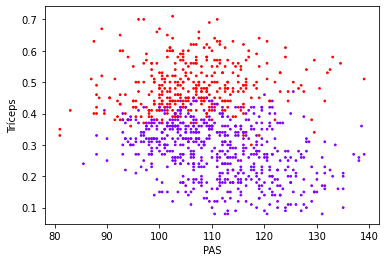

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(data_dobrados_normalizados['SBP'], data_dobrados_normalizados['Fat_Index'], c=labels_KMeans, s=3, cmap='rainbow')
plt.xlabel("PAS")
plt.ylabel("Tríceps")
plt.show

In [ ]:
data_dobrados_normalizados =  data_dobrados.copy()
values = Normalizer().fit_transform(data_dobrados_normalizados.values)

for i in range (2, 10):
    s, dbs, calinski,labels_KMeans, kmeans = clustering_algorithm(i, values)
    print(i,s,dbs,calinski, labels_KMeans[:5])  


2 0.3552860249273135 1.0598752849225208 701.6605678991081 [0 0 1 1 1]
3 0.2832458568157853 1.1924715957984098 605.3435124874551 [1 1 0 0 0]
4 0.2754656688802949 1.1318570333094349 584.7260462151042 [0 0 0 0 0]
5 0.2559089504672959 1.1839707862186486 525.7161514312492 [4 4 4 4 4]
6 0.23538921946118754 1.2303451008757822 491.22815691572464 [4 4 5 4 5]
7 0.23141867893384993 1.2334325648737587 455.09071850787444 [5 5 0 0 3]
8 0.22124837519439106 1.264579593695106 427.62634808213215 [0 0 3 3 3]
9 0.2204915656601517 1.2589422934007548 401.0174879141398 [2 2 5 5 5]


In [ ]:
s, dbs, calinski,labels_KMeans, kmeans = clustering_algorithm(2, values)

centroids = kmeans.cluster_centers_
max =len(centroids[0])
for i in range(max):
    print(data_dobrados_normalizados.columns.values[i], "\n{:.4f}".format (centroids[:, i].var()))


Length 
0.0000
Circumference 
0.0001
Triceps_Skinfold 
0.0026
Fat_Index 
0.0000
DBP 
0.0000
SBP 
0.0001


In [ ]:
data_dobrados_normalizados["cluster"] = labels_KMeans
description = data_dobrados_normalizados.groupby("cluster")
n = description.size()
description = print(description.mean())
print(description)

            Length  Circumference  Triceps_Skinfold  Fat_Index        DBP  \
cluster                                                                     
0        32.631875      28.880163         26.454348   0.488478  64.567935   
1        34.214852      26.187705         12.645410   0.282426  64.801639   

                SBP  
cluster              
0        106.403533  
1        110.974590  
None


<function matplotlib.pyplot.show>

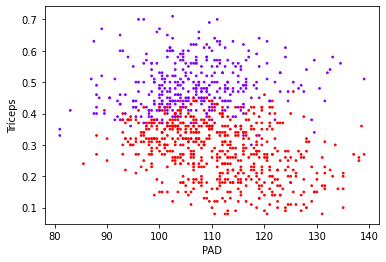

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(data_dobrados_normalizados['SBP'], data_dobrados_normalizados['Fat_Index'], c=labels_KMeans, s=3, cmap='rainbow')
plt.xlabel("PAD")
plt.ylabel("Tríceps")
plt.show

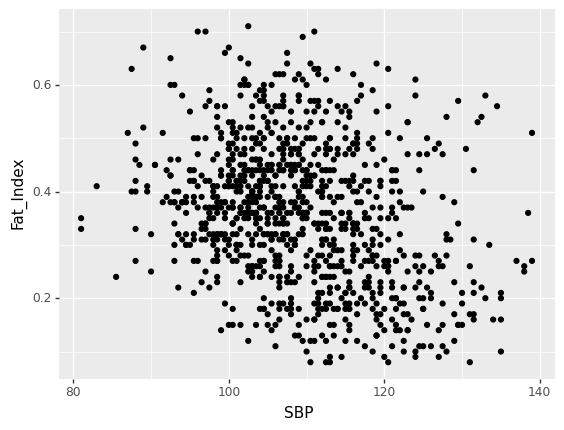

<ggplot: (8775387557193)>

In [ ]:
(
    ggplot(data_dobrados, aes(x='SBP', y='Fat_Index')) + 
    geom_point()
)

## <font color=green>data direito</font>

In [ ]:
data_bd.drop(columns=['arm', 'id','SBP_ob'], inplace=True)
data_bd.head()

,Length,Circumference,Triceps_Skinfold,Fat_Index,DBP,SBP
0,38.00,31.5,14.7,0.27,62.0,106.5
1,28.83,25.3,22.3,0.48,56.5,100.0
2,34.13,22.4,24.0,0.56,58.5,98.5
3,34.10,27.9,9.0,0.19,66.0,122.0
4,29.43,28.9,37.3,0.65,64.0,101.5


In [ ]:
data_bd_normalizados =  data_bd.copy()
values = Normalizer().fit_transform(data_bd_normalizados.values)

random_data = np.random.rand(values.shape[0],values.shape[1])
s, dbs, calinski, labels_KMeans, kmeans = clustering_algorithm(2, random_data)
print(f"Baseline 2 clusters - {s}, {dbs}, {calinski}")

for i in range (2, 10):
    s, dbs, calinski,labels_KMeans, kmeans = clustering_algorithm(i, values)
    print(i,s,dbs,calinski, labels_KMeans[:5])  


Baseline 2 clusters - 0.0015965590575493765, 1.0920687895368526, 330.71677192782505
2 0.3404983257205297 1.0920687895368526 330.71677192782505 [0 1 1 0 1]
3 0.2942095894148156 1.1682478561701493 302.5786774116185 [1 2 2 0 2]
4 0.27870462772302945 1.1313492790962876 293.0042401128824 [3 3 3 0 1]
5 0.26241290009228874 1.1567292320433524 265.83829950252704 [1 1 1 2 3]
6 0.23793775322155475 1.2220132626251516 246.69694891063864 [5 4 4 0 1]
7 0.2388776500698859 1.1679936409143064 229.23050713365066 [5 3 2 6 4]
8 0.23434792557314005 1.2291645087170395 214.6391544191084 [4 3 3 5 2]
9 0.22373158685266126 1.269240643761057 204.18544810467034 [8 2 2 4 3]


In [ ]:
s, dbs, calinski,labels_KMeans, kmeans = clustering_algorithm(2, values)

centroids = kmeans.cluster_centers_
max =len(centroids[0])
for i in range(max):
    print(data_bd_normalizados.columns.values[i], "\n{:.4f}".format (centroids[:, i].var()))


Length 
0.0000
Circumference 
0.0001
Triceps_Skinfold 
0.0026
Fat_Index 
0.0000
DBP 
0.0000
SBP 
0.0002


In [ ]:
data_bd_normalizados["cluster"] = labels_KMeans
description = data_bd_normalizados.groupby("cluster")
n = description.size()
description = print(description.mean())
print(description)

            Length  Circumference  Triceps_Skinfold  Fat_Index        DBP  \
cluster                                                                     
0        32.687663      28.802717         27.013587   0.497663  63.877717   
1        34.286623      26.266557         13.370164   0.296066  64.090164   

                SBP  
cluster              
0        106.565217  
1        111.929508  
None


<function matplotlib.pyplot.show>

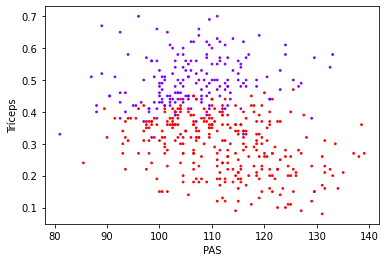

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(data_bd_normalizados['SBP'], data_bd_normalizados['Fat_Index'], c=labels_KMeans, s=3, cmap='rainbow')
plt.xlabel("PAS")
plt.ylabel("Tríceps")
plt.show

In [1]:
def compara_medias(data1, data2):
    p_list = list()
    p_compara = list()
    for i in data1.columns:
        u, p_valor = mannwhitneyu(data1[[i]], data2[[i]])
        if p_valor[0] <= significancia:
            p_compara.append("Médias diferentes")
        else:
            p_compara.append("Médias iguais")
        p_list.append(p_valor[0])
    return p_list, p_compara

In [2]:
compara_medias(data_bd_normalizados.query("cluster == 0"),data_bd_normalizados.query("cluster == 0"))

NameError: ignored

## <font color=green>data esquerdo</font>

In [ ]:
data_be.drop(columns=['arm', 'id','SBP_ob'], inplace=True)
data_be.head()

,Length,Circumference,Triceps_Skinfold,Fat_Index,DBP,SBP
0,36.50,30.8,17.7,0.33,60.5,112.5
1,30.43,25.0,22.3,0.48,56.5,102.0
2,33.00,22.8,23.7,0.55,59.0,95.0
3,33.67,27.4,6.3,0.14,70.5,121.5
4,29.80,29.5,34.3,0.60,64.5,101.5


In [ ]:
data_be_normalizados =  data_be.copy()
values = Normalizer().fit_transform(data_be_normalizados.values)

for i in range (2, 10):
    s, dbs, calinski,labels_KMeans, kmeans = clustering_algorithm(i, values)
    print(i,s,dbs,calinski, labels_KMeans[:5])  


2 0.3686391733064128 1.0221778084575632 382.53335725250344 [1 0 0 1 0]
3 0.2867393848969643 1.1777896995015655 321.3619567696569 [1 0 0 1 0]
4 0.2713300061369893 1.1438252814097702 303.1687300848239 [1 1 1 0 2]
5 0.249285778031124 1.2156921482602825 270.7851952040784 [0 3 3 2 1]
6 0.23814673319808916 1.179386052179107 253.08005687490856 [0 5 5 1 2]
7 0.22853061690641516 1.2472557729762805 233.53699007871236 [2 6 1 0 5]
8 0.21856477697854282 1.3190661725684503 220.72921518619938 [3 6 1 4 5]
9 0.217805774452563 1.295198810665876 207.96794925127756 [4 1 2 6 8]


In [ ]:
s, dbs, calinski,labels_KMeans, kmeans = clustering_algorithm(2, values)

centroids = kmeans.cluster_centers_
max =len(centroids[0])
for i in range(max):
    print(data_be_normalizados.columns.values[i], "\n{:.4f}".format (centroids[:, i].var()))


Length 
0.0000
Circumference 
0.0001
Triceps_Skinfold 
0.0026
Fat_Index 
0.0000
DBP 
0.0000
SBP 
0.0001


In [ ]:
data_be_normalizados["cluster"] = labels_KMeans
description = data_be_normalizados.groupby("cluster")
n = description.size()
description = print(description.mean())
print(description)

            Length  Circumference  Triceps_Skinfold  Fat_Index        DBP  \
cluster                                                                     
0        34.116828      26.197411         12.043689   0.270032  65.346278   
1        32.586333      28.868889         25.994444   0.481833  65.538889   

                SBP  
cluster              
0        110.090615  
1        106.036111  
None


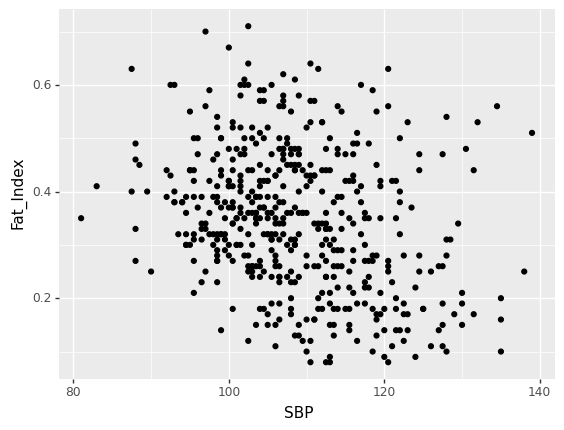

<ggplot: (8775385949437)>

In [ ]:
(
    ggplot(data_be_normalizados, aes(x='SBP', y='Fat_Index')) + 
    geom_point()
)

<function matplotlib.pyplot.show>

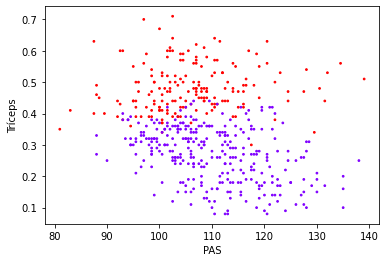

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(data_be_normalizados['SBP'], data_be_normalizados['Fat_Index'], c=labels_KMeans, s=3, cmap='rainbow')
plt.xlabel("PAS")
plt.ylabel("Tríceps")
plt.show

In [ ]:
from scipy.stats import wilcoxon
significancia = 0.05

In [ ]:

def compara_medias_wilcoxon(data1, data2):
    p_list = list()
    p_compara = list()
    for i in data1.columns:
        u, p_valor = wilcoxon(data1[i], data2[i])
        if p_valor <= significancia:
            p_compara.append("Médias diferentes")
        else:
            p_compara.append("Médias iguais")
        p_list.append(p_valor)
    return p_list, p_compara

In [ ]:
compara_medias_wilcoxon(data_be_normalizados.query("cluster == 1"), data_be_normalizados.query("cluster == 0"))

ValueError: ignored